# Assignment 8 Analysis
In this assignment, I walk through the data performing various analysis

In [2]:
# Import necessary libraries
%matplotlib inline

from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import *
import csv
from mpl_toolkits.mplot3d import Axes3D

In [3]:
# Read in the data
data = open('../data/data.csv', 'r').readlines()
fieldnames = ['x', 'y', 'z', 'unmasked', 'synapses']
reader = csv.reader(data)
reader.next()

rows = [[int(col) for col in row] for row in reader]

# Format the data sorted by physical location on slide
sorted_x = sorted(list(set([r[0] for r in rows])))
sorted_y = sorted(list(set([r[1] for r in rows])))
sorted_z = sorted(list(set([r[2] for r in rows])))

In [4]:
# Synapse data (as in rows from last code block) considering only unmasked synapses
unmaskedSynapses = ([r[-1] for r in rows if r[-2] != 0])

# Synapse data considering only unmasked synapses with non-zero density values
unmaskedSynapsesNoZero = ([r[-1] for r in rows if r[-2] != 0 if r[-1] !=0])

real_volume = np.zeros((len(sorted_x), len(sorted_y), len(sorted_z)))
for r in rows:
    real_volume[sorted_x.index(r[0]), sorted_y.index(r[1]), sorted_z.index(r[2])] = r[-1]

## Kernal Density Estimation

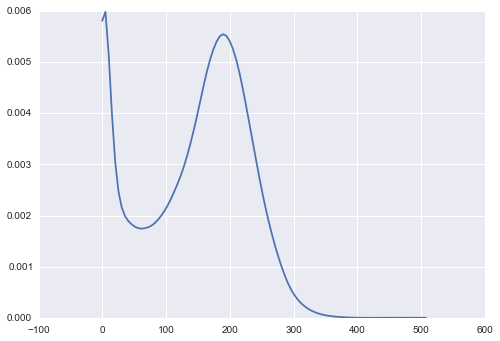

In [5]:
unmaskedSynapses = np.asarray(unmaskedSynapses)
sns.kdeplot(unmaskedSynapses)

## Examining xy density projections through image z layers
This didn't work how I wanted to, but there is more I can do here.

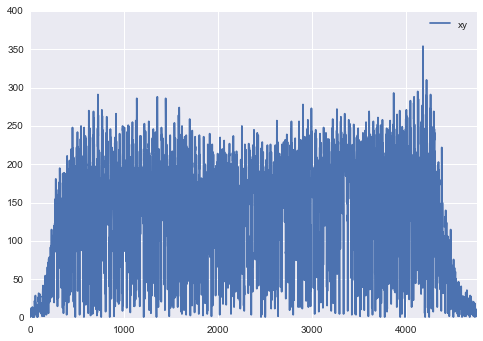

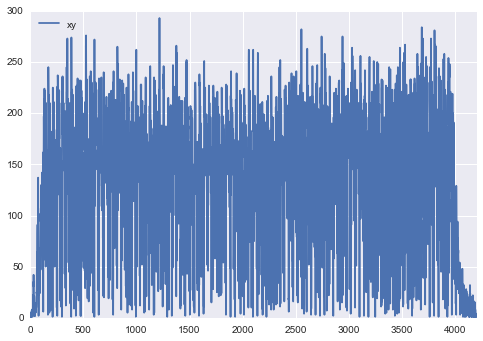

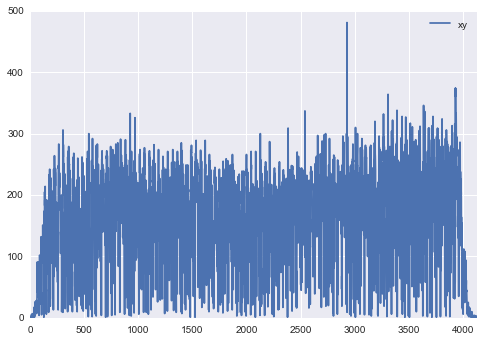

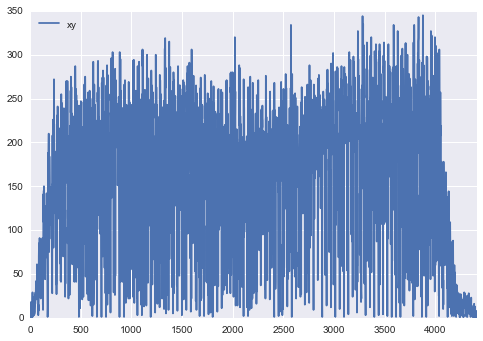

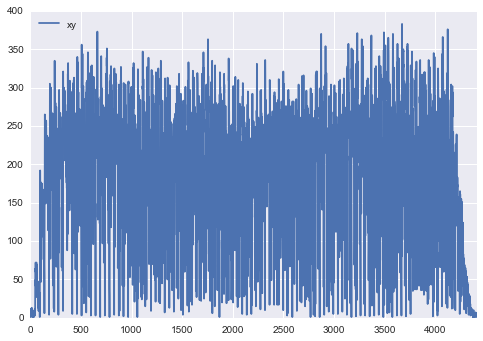

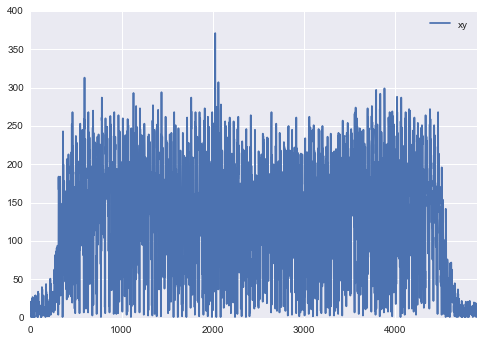

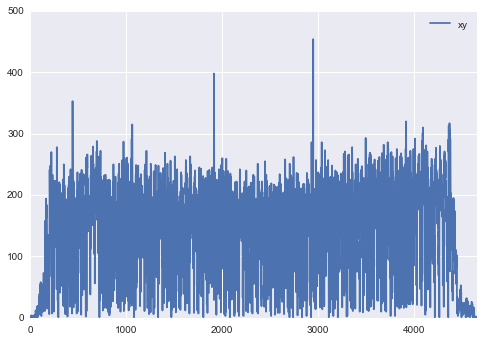

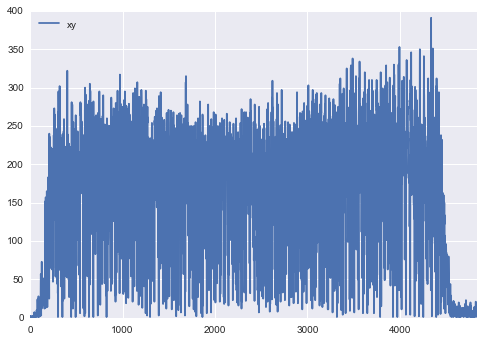

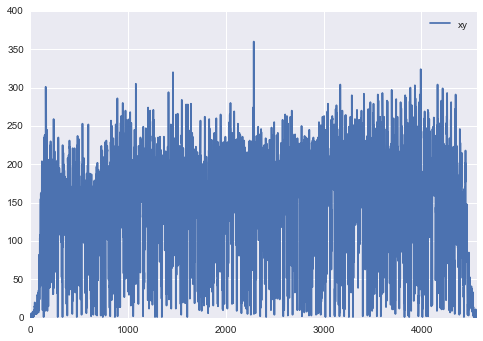

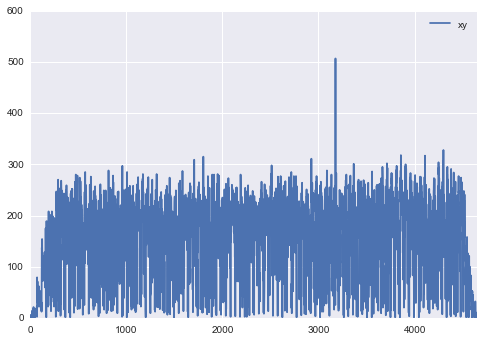

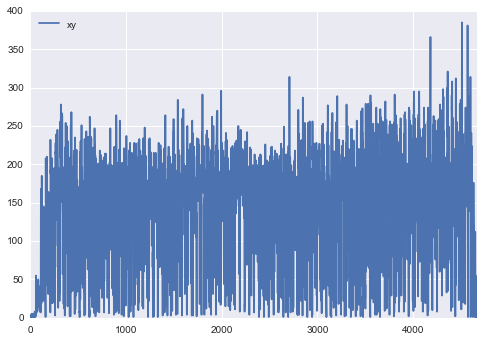

In [6]:
count = 0
for i in sorted_z:
    unmaskedSynapsesNoZero = ([r[-1] for r in rows if r[-2] != 0 if r[-1] !=0 if r[2] == i])
    # convert to pandas dataframe
    df = pd.DataFrame(unmaskedSynapsesNoZero, columns=['xy'])
    df.plot()
    count = count + 1
    
# df
    
#     syn_den = sns.load_dataset(df)

## Single-layer heat map

/Library/Python/2.7/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


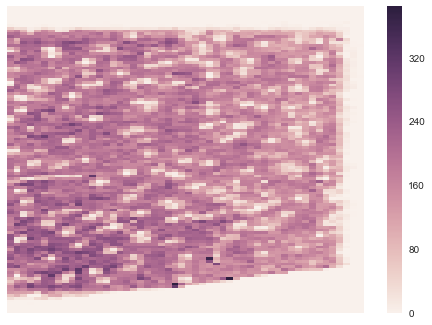

In [7]:
count = 0
for i in sorted_z:
    df = pd.DataFrame(real_volume[:,:,count])
#     print real_volume[:,:,count]
#     ax = sns.heatmap(df)
    count = count + 1
    
ax = sns.heatmap(df, yticklabels=False, xticklabels=False)
    
#     syn_den = sns.load_dataset(df)
    

## Cluster map

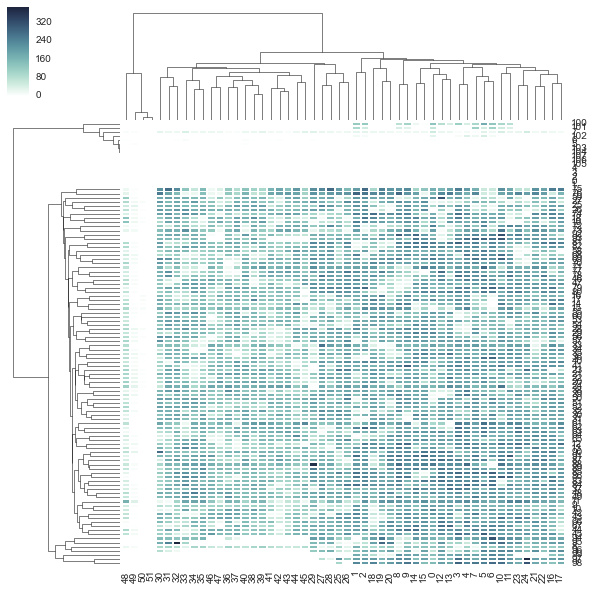

In [8]:
cmap = sns.cubehelix_palette(as_cmap=True, rot=-.3, light=1)
g = sns.clustermap(df, cmap=cmap, linewidths=.5)

## Cluster map with standardization across columns

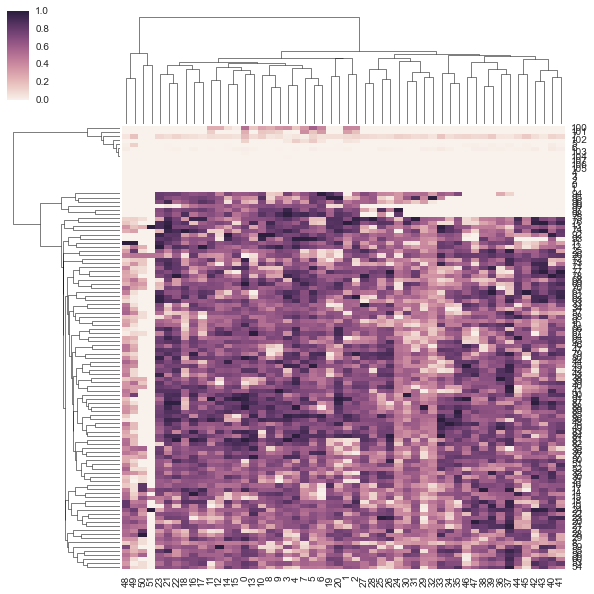

In [9]:
# standardize data across all columns
g = sns.clustermap(df, standard_scale=1)

## Analysis using Principal Components

### PCA from single 2D Layer
Here we use a single z layer and find the principle components

In [10]:
pca = PCA(n_components=5)
pca.fit(df)
print(pca.explained_variance_ratio_)

[ 0.54632801  0.06806289  0.03887388  0.03446306  0.03072315]


### Explained Variance

[ 0.54632801  0.06806289  0.03887388  0.03446306  0.03072315]


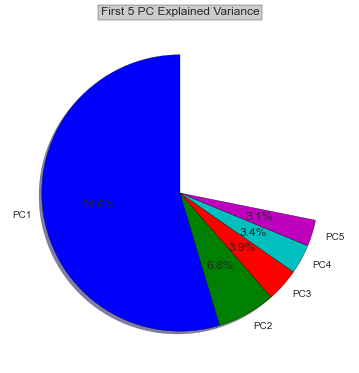

In [11]:
# make a square figure and axes
figure(1, figsize=(6,6))
ax = axes([0.1, 0.1, 0.8, 0.8])

# The slices will be ordered and plotted counter-clockwise.
labels = 'PC1', 'PC2', 'PC3', 'PC4', 'PC5'
fracs = pca.explained_variance_ratio_
print fracs

pie(fracs, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)

title('First 5 PC Explained Variance', bbox={'facecolor':'0.8', 'pad':5})

show()

We can see how the first five pricipal components explain variance in the 2D z-layers ("z" w.r.t. image, not brain) 

### PCA from single all three dimensions
We want to use PCA to go from 3D data --> 2D. This can help us visualize data, and will reorient our view hopefully in such a way that we can see brain layers.

First, let's see what the 3D data looks like:

In [12]:
ax.scatter(real, y, z, c='b')

NameError: name 'y' is not defined

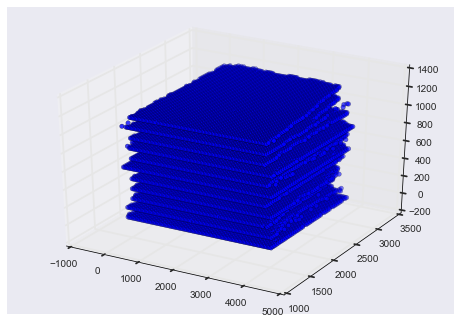

In [13]:
#Attempt to plot the entire data set in 3d in order to find some other characteristics?
#The plot does not look that great. Too dense. Needs adjustment
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

#print unmaskedSynapsesNoZero
x = []
y = []
z = []
val = []

for r in rows:
    if r[-2] != 0:
        if r[-1] !=0:
            x.append(r[0])
            y.append(r[1])
            z.append(r[2])
            
ax.scatter(x, y, z, c='b')
plt.show()

This plot is too messy. It also doesn't say much about the density at particular locations. To solve this, we need to do two things:
* Make scatter marker size based on the density
* Find a threshold and ignore the least dense points

I'll start by making a function that does these plots so we don't copy paste.

In [14]:
def make3DSynapsePlot(thresh):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    x = []
    y = []
    z = []
    d = []
    val = []

    for r in rows:
        if r[-2] != 0:
            # Filtering 
            if r[-1] > thresh:
                x.append(r[0])
                y.append(r[1])
                z.append(r[2])
                d.append(r[-1])

    ax.scatter(x, y, z, c='b')
    plt.show()

We know from our histogram that there is a density peak around 190. Let's start by filtering out points below this peak.

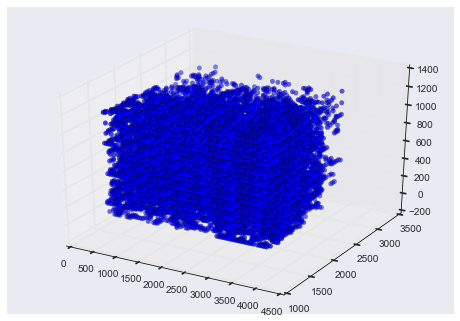

In [15]:
make3DSynapsePlot(190)

This is still too dense. Let's really crank up the threshold to 280.
Note: In the future, I want to use standard deviation to determine this. While this would be easy on the raw data, we actually want to use the standard deviation on the second gaussian given by gmm. (@richie)

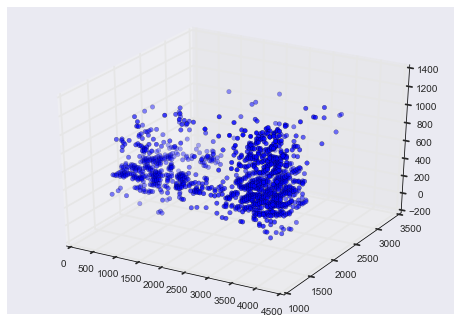

In [16]:
make3DSynapsePlot(280)

That's more like it! Now, let's add in some density information. We can base the bubble size by the density at that location.

In [55]:
def make3DSynapsePlot(thresh):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    x = []
    y = []
    z = []
    d = []
    val = []

    for r in rows:
        if r[-2] != 0:
            # Filtering 
            if r[-1] > thresh:
                x.append(r[0])
                y.append(r[1])
                z.append(r[2])
                d.append(r[-1])
                
    #Scale and raise it to appropriate power
    dens = [((i-min(d))**1.2) for i in d]

    ax.scatter(x, y, z, c='b', s=dens)
    fig.suptitle('3D Distribution of Synapses', fontsize=20)
    return ax


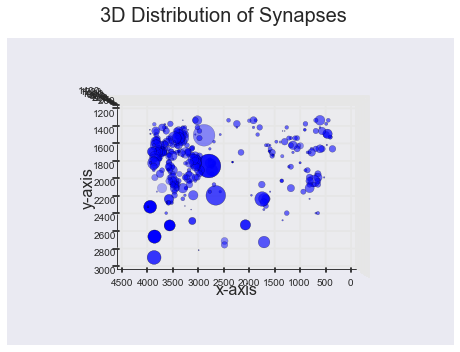

In [67]:
ax = make3DSynapsePlot(310)
ax.set_xlabel('x-axis', fontsize=16)
ax.set_ylabel('y-axis', fontsize=16)
# ax.set_zlabel('z-axis', fontsize=16)
ax.view_init(elev=90, azim=90)
plt.show()

In [ ]:
def plot_figs(fig_num, elev, azim):
    fig = plt.figure(fig_num, figsize=(4, 3))
    plt.clf() #clear the figure
    ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=elev, azim=azim)

    ax.scatter(x[::10], y[::10], z[::10], c='b', marker='+', alpha=.4)
    Y = np.c_[x, y, z]

    # Using SciPy's SVD, this would be:
    # _, pca_score, V = scipy.linalg.svd(Y, full_matrices=False)

    pca = PCA(n_components=3)
    pca.fit(Y)
    pca_score = pca.explained_variance_ratio_
    V = pca.components_

    x_pca_axis, y_pca_axis, z_pca_axis = V.T * pca_score / pca_score.min()

    x_pca_axis, y_pca_axis, z_pca_axis = 3 * V.T
    x_pca_plane = np.r_[x_pca_axis[:2], - x_pca_axis[1::-1]]
    y_pca_plane = np.r_[y_pca_axis[:2], - y_pca_axis[1::-1]]
    z_pca_plane = np.r_[z_pca_axis[:2], - z_pca_axis[1::-1]]
    x_pca_plane.shape = (2, 2)
    y_pca_plane.shape = (2, 2)
    z_pca_plane.shape = (2, 2)
    ax.plot_surface(x_pca_plane, y_pca_plane, z_pca_plane)
    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])


elev = -40
azim = -80
plot_figs(1, elev, azim)

# elev = 30
# azim = 20
# plot_figs(2, elev, azim)

plt.show()

### Transforming data to PC

In [ ]:
pca.transform(df)

In [ ]:
# Plot the transformed data

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = []
y = []
z = []
val = []

for r in rows:
    if r[-2] != 0:
        if r[-1] !=0:
            x.append(r[0])
            y.append(r[1])
            z.append(r[2])
            
ax.scatter(x, y, z, c='b')
plt.show()